In [1]:
# Author: Zhuyun Ye, Niels S. Hvidberg
# copied to Niels 01/03 2024
# Description: Python script usefull for working with NetCDF
#              and contain tools to convert DEHM binary output 
#              to NetCDF files. The conversion requires a 
#              species file which is not present in the current
#              SPA_DEHM model.

In [2]:
# Import packages
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import datetime as dt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# Printing text in colors
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


In [4]:
def show(xr_dataset):
    """
    This function gives you a way to display xarray datasets per command, instead of implicitly
    by calling the dataset instance as the last thing in a cell.
    """
    from IPython.display import display, HTML
    display(HTML(xr.core.formatting_html.dataset_repr(xr_dataset)))

In [5]:
def xr_open_old(data_dir, days=[1, 31], hours=[0, 23]):
    infile = []
    dataset = []
    for i in range(days[0], days[1]+1):
        if (i == 1):
            z = 1
        else:
            z = 0
    
        for j in range(z+hours[0], hours[1]+1):
            name = f'201101{i:02d}{j:02d}.nc'
            infile.append(data_dir+'/'+name)
            dataset.append(xr.open_dataset(infile[-1]))
    
    return dataset

def xr_open(data_dir, days=[1, 31], hours=[0, 23]):
    infile = []
    dataset = []
    for i in range(days[0], days[1]+1):
        if (i == 1):
            z = 1
        else:
            z = 0
    
        for j in range(z+hours[0], hours[1]+1):
            name = f'1_201101{i:02d}{j:02d}.nc'
            infile.append(data_dir+'/'+name)
            dataset.append(xr.open_dataset(infile[-1]))
    
    return dataset

In [17]:
# Choose case and scroll down to the relevant section
case = 11

# DEHM data
if case == 1 :
    dir1 = 'netcdf1'
    dir2 = 'netcdf2'
    dir3 = 'netcdf3'
    dir4 = 'netcdf4'
    
    ds1 = xr_open_old(dir1)
    ds2 = xr_open_old(dir2)
    ds3 = xr_open_old(dir3)
    ds4 = xr_open_old(dir4)
    ds = ds1
    show(ds[0])

if case == 11 :
    ds1 = xr.open_dataset('nc/cams.nc')
    ds2 = xr.open_dataset('nc/jena.nc')
    ds=ds1
    show(ds)
    
if case == 111 :
    dir1 = 'only_cams_glob/2011/netcdf'
    dir2 = 'only_jena_ocn/2011/netcdf'
    
    ds1 = xr_open(dir1)
    ds2 = xr_open(dir1)
    ds = ds1
    show(ds[0])

# CAMS data
if case == 2 :
    infile_cams       = '/home/niels/Documents/Data/CAMS/CAMS-GLOB/CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_co2_excl_short-cycle_org_C_v5.3_monthly.nc'
    ds_cams  = xr.open_dataset(infile_cams)
    ds       = ds_cams
    show(ds)

# Jena data
if case == 3 : 
    infile_jena = '/home/niels/Documents/Data/JENA/oc_v2023.pCO2.nc'
    ds_jena = xr.open_dataset(infile_jena)
    ds = ds_jena
    show(ds)

## Working with dehm data to create animations

In [18]:
def dehm_plotter(dataset, index=12, meandim='z', species="CO2.01", close=False, central_longitude=-32, output_dir='frames'):
    """
    Docstring for dehm_plotter:
        This function is used to plot netCDF files (output from DEHM) on a polar
        stereographic map.

        dataset: A list of xarray-dataset objects with 3D field data.
        index: The index for the specific dataset to workwith in dataset list.
        meandim: Calculate the mean over this dimension. Most often 'time' or 'z'.
        species: the kind to plot. For DEHM CO2 the tracers are called CO2.ntrac 
        (1 indexing!).

        The function creates a plot, saves it and can also close the plot again. The
        plot is saved under the name:
        
            f'{output_dir}/frame{index:03d}.png'
    """
    if meandim:
        da = dataset[index][species].mean(dim=meandim)
        lat = dataset[index]['lat'].values
        lon = dataset[index]['lon'].values
    if meandim == 0:
        da = dataset[species].isel(z=0)
        lat = dataset['lat'].values
        lon = dataset['lon'].values
    else:
        da = dataset[index][species].isel(z=0)
        lat = dataset[index]['lat'].values
        lon = dataset[index]['lon'].values
        

    
    # Get values
    pdata = da.values

    # Set min/max values for plots:
    vmin = da.min()
    vmax = da.max()*0.9
    
    # This is the map projection we want to plot *onto*
    map_proj = ccrs.NorthPolarStereo(central_longitude=central_longitude)
    fig, ax = plt.subplots(subplot_kw={'projection': map_proj}, figsize=(7,7))

    # Set coastline appearance
    ax.coastlines(color='black',zorder=2,alpha=1,linewidth=1.5)

    # Set gridlines appearance
    gl = ax.gridlines(draw_labels=True, zorder=1, alpha=0.7, linewidth=1, crs=ccrs.PlateCarree())

    # Set label style
    gl.xlabel_style = {'size':7}
    gl.ylabel_style = {'size':7}
    
    # Set colormap
    cmap = plt.get_cmap('jet')
    cmap.set_bad('w',1.0)

    # Plot image
    im = ax.pcolormesh(lon,
                       lat,
                       pdata,
                       cmap=cmap,
                       vmin=vmin, # Min value for colormap (especially used for videos)
                       vmax=vmax,   # Max value for colormap
                       transform=ccrs.PlateCarree(),
                       zorder=0,  # ?
                       shading='auto')

    # Colorbar
    fig.colorbar(im, ax=ax)
    
    # Check if plot should be closed and saved instead of shown (Used for creating frames)
    if close:
        plt.savefig(f'{output_dir}/frame{index:03d}.png')
        plt.close(fig)

def make_frames_from_list(dataset, meandim, species, central_longitude=-32, output_dir='frames'):
    index = 0
    for i in range(1,32):
        if (i == 1):
            z = 1
        else:
            z = 0
    
        for j in range(z,24):
            dehm_plotter(dataset=dataset, index=index, meandim=meandim, species=species, close=True, central_longitude=central_longitude, output_dir=output_dir)
            index += 1

In [19]:
species = f'CO2.{1:02d}'
meandim = []
central_longitude=-32

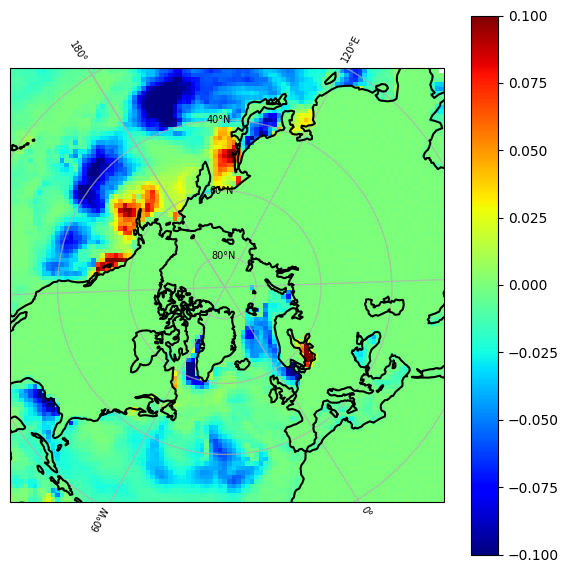

In [20]:
dehm_plotter(dataset=ds2,
             index=100,  
#            meandim=meandim, 
             meandim=0, 
             species=species, 
             close=False, 
             central_longitude=central_longitude, 
            )
plt.savefig('jena_ocean.png')

In [37]:
if True:
    make_frames_from_list(dataset=ds1, meandim=meandim, species=species, central_longitude=central_longitude, output_dir='frames1')
    make_frames_from_list(dataset=ds2, meandim=meandim, species=species, central_longitude=central_longitude, output_dir='frames2')
    #make_frames_from_list(dataset=ds3, meandim=meandim, species=species, central_longitude=central_longitude, output_dir='frames3')
    #make_frames_from_list(dataset=ds4, meandim=meandim, species=species, central_longitude=central_longitude, output_dir='frames4')

To make a video from the frames, run this function with the desired directory as input:

> ./make_video n
> 
> ffmpeg -y -i frames\\$1/frame%03d.png -c:v libx264 -pix_fmt yuv420p video/video\\$1.mp4

n is the first argument and thus becomes $1. n is the label for the directory and output so the function reads in from frames{n} and writes to videos/video{n}.mp4.

In [38]:
!./make_video 1
!./make_video 2
# !./make_video 3
# !./make_video 4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

## Working with JENA netCDF data

In [74]:
# Find the index for a specific time:
# 2011 = 19723
sel_time = '2011-01'
_ = np.argwhere(ds.mtime.values==ds.mtime.sel(mtime=sel_time,method='nearest').values)[0]

array([19723])

In [77]:
# Example of using slice to select slices of the data. 
# This can both be done with isel (using index) or sel (using values)
_ = ds['mtime'].isel({'mtime':slice(19723,19754)})
del _

In [15]:
def JENA_plotter(dataset, species, isel={'mtime':0}, sel={}, close=False, central_longitude=-32, output_dir='plots', figspec='pCO2'):
    """
    Docstring for "JENA_plotter":
        This function is used to plot netCDF files on a polar
        stereographic map.

        dataset  : A list of xarray-dataset objects with 3D field data.
        species  : The kind to plot. For DEHM CO2 the tracers are called CO2.ntrac 
        isel/sel : A dictionary containing the variable and value or slices to choose
                   in the form {var:val/slice/index}. "isel" goes
                   by index and "sel" goes by value.
        meandim  : Calculate the mean over this dimension. Most often 'time' or 'z'.

        The function creates a plot and optionally saves and closes the plot again. The
        plot is saved under the name:
        
            f'{output_dir}/{figname}.png'
    """
    # Select values by index/slice/value.
    if isel:
        da = dataset[species].isel(isel)
    if sel:
        da = dataset[species].sel(sel)
    else:
        da = dataset[species].isel(mtime=0)

    # Set latitude and longitude values
    lat, lon = da['lat'].values, da['lon'].values
    
    # plot the first layer
    pdata = da.values
    
    # This is the map projection we want to plot *onto*
    map_proj = ccrs.NorthPolarStereo(central_longitude=central_longitude)
    fig, ax = plt.subplots(subplot_kw={'projection': map_proj}, figsize=(7,7))

    # Set appearance for coastlines
    ax.coastlines(color='black',zorder=2,alpha=1,linewidth=1.5)

    # Set appearance for gridlines
    gl = ax.gridlines(draw_labels=True, zorder=1, alpha=0.7, linewidth=1, crs=ccrs.PlateCarree())

    # Set label size
    gl.xlabel_style = {'size':7}
    gl.ylabel_style = {'size':7}

    # Set colormap
    cmap = plt.get_cmap('jet')
    cmap.set_bad('w',1.0)
    
    # Plot image
    im = ax.pcolormesh(lon,
                       lat,
                       pdata,
                       cmap=cmap,
#                      vmin=-0.1, # Min value for colormap (especially used for videos)
#                      vmax=14,   # Max value for colormap
                       transform=ccrs.PlateCarree(),
                       zorder=0,  # ?
                       shading='auto')

    # Set Colorbar
    fig.colorbar(im, ax=ax)

    # Check if plot should be closed and saved instead of shown (Used for creating frames)
    if close:
        figname = f'plot_{figspec}.png'
        plt.savefig(f'{output_dir}/{figname}.png')
        plt.close(fig)

In [15]:
species = 'pCO2'
# domain 4
sel={'mtime':ds['mtime'].values[0], 'lat':slice(55.0,57.0), 'lon':slice(8.0,16.0)}
# Domain 1
sel={'mtime':ds['mtime'].values[0], 'lat':slice(20.0,90.0), 'lon':slice(-180.0,180.0)}
central_longitude=-32
# print(ds[species].sel(sel)) # Testing settings

KeyError: "No variable named 'mtime'. Variables on the dataset include ['z', 'x', 'y', 'height', 'lon', 'lat', 'surface_pressure', 'CO2.01']"

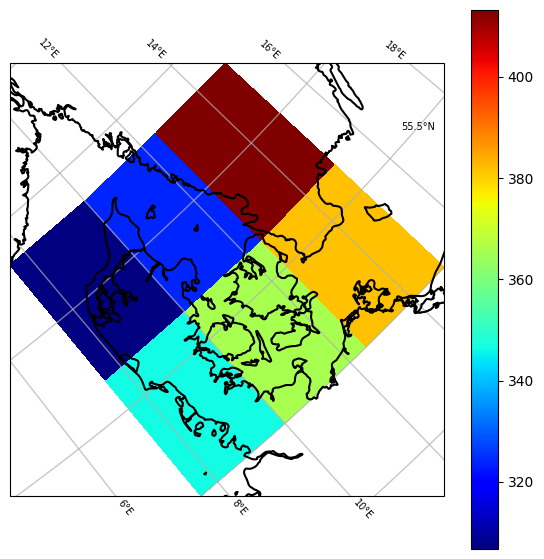

In [17]:
JENA_plotter(dataset=ds,
             species=species,
             sel=sel,
             central_longitude=central_longitude,
             output_dir='plots',
             figspec='pCO2',
            )

## Working with CAMS netCDF data

### Key names/descriptions
*get by calling:* list(ds.data_vars)
 1. ags - Agricultural soil
 2. ene - Power generation
 3. fef - Fugitive emissions from fuels
 4. ind - Industrial processes
 5. ref - Refineries and fuel industries
 6. res - Residential
 7. shp - Ships
 8. slv - Solvents application and production
 9. sum - Sum of sectors
10. swd - Solid waste and wastewater handeling
11. tnr - Non-road transport
12. tro - Road transport

species: ind



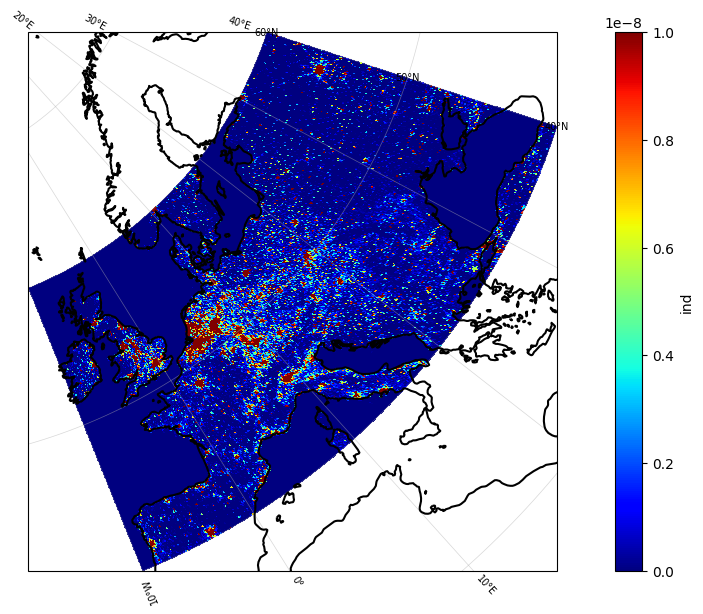

In [10]:
species = 'ind'
#species = list(ds.data_vars)[5]

print('species:', species)
print()

sel_eu = {'time':'2024-06-01', 'lat':slice(40.0,60.0), 'lon':slice(-10.0,40.0)}
sel_dk = {'time':'2024-06-01', 'lat':slice(54.0,58.0), 'lon':slice(7.0,15.5)}
sel = sel_eu

# Select values by index/slice/value.
da = ds[species].sel(sel)

# Set latitude and longitude values
lat, lon = da['lat'].values, da['lon'].values

# plot the first layer
pdata = da.values

# This is the map projection we want to plot *onto*
map_proj = ccrs.NorthPolarStereo(central_longitude=32)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-32)}, figsize=(15,7))
ax.coastlines(color='black',zorder=2,alpha=1,linewidth=1.5)
gl = ax.gridlines(draw_labels=True,zorder=1,alpha=0.5,linewidth=0.5,crs=ccrs.PlateCarree())
gl.xlabel_style = {'size':7}
gl.ylabel_style = {'size':7}

cmap = plt.get_cmap('jet')
cmap.set_bad('w',1.0)

im = ax.pcolormesh(lon, lat, pdata, cmap=cmap,
     vmin=0, vmax=1e-8,
    transform=ccrs.PlateCarree(),
    zorder=0, shading='auto')

plt.colorbar(im, ax=ax, orientation='vertical',label=species)
plt.show();

In [11]:
# Checking if the key 'sum' is equal to the actual sum.
from decimal import *

getcontext().prec = 12

ds_no_sum = ds.drop_vars('sum')
sum_sample = 0

ds_no_sum = ds_no_sum.sel(time='2023-01-01', lat=0, lon=0, method='nearest')

for key in ds_no_sum:
    sum_sample =+ ds_no_sum[key].values

print('Manual sum:', f'{sum_sample:+.8e}')
print('Automatic sum:', ds['sum'].sel(time='2023-01-01', lat=0, lon=0, method='nearest').values)
if np.isclose(sum_sample,ds['sum'].sel(time='2023-01-01', lat=0, lon=0, method='nearest').values):
    print("'sum' is correct!", bcolors.OKGREEN + u'\u2713' + bcolors.ENDC)


Manual sum: +0.00000000e+00
Automatic sum: 2.4606109e-11
'sum' is correct! ✓


In [12]:
# Selecting a specific date/month/year will give you all data within that time unit, ie. for a date 'yyyy-mm-dd'
# you get everything between yyyy-mm-dd-00:00:00 to yyyy-mm-dd-23:59:59, for a month you get all data from 
# yyyy-mm-01-00:00:00 to yyyy-mm-31-23:59:59, for a year you get yyyy-01-01-00:00:00 to yyyy-12-31-23:59:59.
_ = ds['ags'].sel(time='2023-01-01', lat=0, lon=0, method='nearest').values